In [1]:
import shioaji as sj

api = sj.Shioaji(simulation=True)
accounts = api.login(
    api_key="3WmNiNGCQMuPGsRMdpgML3MWYkqM1gExzPUGKKcjhufd",     # 請修改此處
    secret_key="EnKAve1Ldd8wuerMRcwKUUrB4DRmLyoxCSyoApmbzrTM"   
)

2023-05-29 10:08:27.953 | WARNING  | importlib._bootstrap:_call_with_frames_removed:228 - Optional: pip install shioaji[speed] for better performance.


Response Code: 0 | Event Code: 0 | Info: host '203.66.91.161:80', hostname '203.66.91.161:80' IP 203.66.91.161:80 (host 1 of 1) (host connection attempt 1 of 1) (total connection attempt 1 of 1) | Event: Session up


In [28]:
# import datetime
# import pandas as pd
# import os
# import numpy as np

# days = 374

# kbars = api.kbars(
#     contract=api.Contracts.Futures.TXF.TXFR1, 
#     start=(datetime.datetime.now() - datetime.timedelta(days=days)).strftime("%Y-%m-%d"), 
#     end=datetime.datetime.now().strftime("%Y-%m-%d"),
# )

# df = pd.DataFrame({**kbars})
# df.ts = pd.to_datetime(df.ts)
# df = df.set_index('ts')
# df.index.name = None
# df_1min = df

# df_1min = df_1min[['Open', 'High', 'Low', 'Close', 'Volume']]
# df_1min.to_csv('TXF_1min.csv')

使用5分K，日盤資料

In [29]:
df = pd.read_csv(f"TXF_1min.csv", index_col=0)

df.index = pd.to_datetime(df.index)
df_resample = df.resample('5T', label='right', closed='right').agg(
    {'Open'  :'first',
     'High'  :'max',
     'Low'   :'min',
     'Close' :'last',
     'Volume':'sum'
    })
df_resample.dropna(axis=0, inplace=True)
df_all_time = df_resample
print(df_all_time.head())
print(df_all_time.tail())

                        Open     High      Low    Close  Volume
2022-05-20 00:00:00  16003.0  16011.0  16001.0  16009.0     156
2022-05-20 00:05:00  16009.0  16012.0  15997.0  16001.0     547
2022-05-20 00:10:00  16001.0  16007.0  15996.0  16003.0     445
2022-05-20 00:15:00  16005.0  16015.0  16005.0  16010.0     466
2022-05-20 00:20:00  16010.0  16019.0  15999.0  16001.0     485
                        Open     High      Low    Close  Volume
2023-05-29 09:50:00  16576.0  16586.0  16569.0  16580.0    2235
2023-05-29 09:55:00  16580.0  16593.0  16575.0  16584.0    1691
2023-05-29 10:00:00  16584.0  16607.0  16576.0  16599.0    2048
2023-05-29 10:05:00  16599.0  16609.0  16592.0  16604.0    1543
2023-05-29 10:10:00  16604.0  16610.0  16596.0  16597.0     767


策略部分

# 策略(5分K)

**使用威廉指標與SMA指標當作技術指標**

多單策略：

進場：
* WR向上超越超買區(-30)
* SMA黃金交叉
* 開盤15分鐘後進場

出場：
* 百分比停損 0.1%
* 跌破3根低點停利停損 
* WR跌出超買區
* SMA死亡交叉
* 13.30平倉


空單策略：

進場：
* WR向下超越超賣區(-75)
* SMA死亡交叉
* 開盤15分鐘後進場

出場：
* 百分比停損 0.1%
* 超出3根高點停利停損 
* WR向上超出超賣區
* SMA黃金交叉
* 13.30平倉

In [35]:
from backtesting import Strategy
from backtesting.lib import crossover
import talib as ta

from datetime import time

#使用威廉指標當作技術指標
class WL(Strategy): 

    WL = 65
    OB = -15
    stop_pct = 1 #表示0.x%
    OS = -80
    L = 2
    
    n1 = 10
    n2 = 35
    
    fast_period = 12
    slow_period = 26
    signal_period = 9
    proportion = 0.9

    def init(self):
        self.wl = self.I(ta.WILLR, self.data.High, self.data.Low, self.data.Close, self.WL)
        self.macd = self.I(ta.MACD, self.data.Close, fastperiod=self.fast_period, slowperiod=self.slow_period, signalperiod=self.signal_period)
        self.min = self.I(ta.MIN, self.data.Low, self.L)
        self.max = self.I(ta.MAX, self.data.High, self.L)
        self.proportion = 0.9
        
        self.sma1 = self.I(ta.SMA, self.data.Close, self.n1) # sma 快線
        self.sma2 = self.I(ta.SMA, self.data.Close, self.n2) # sma 慢線

    def next(self):
                
        curr_macd = self.macd[2][-1]
        prev_macd = self.macd[2][-2]

        macd_now = self.macd[0][-1]
        signal_now = self.macd[1][-1]

        signal = 0
        # MACD crosses the zero line from below - buy signal
        if prev_macd < 0 and curr_macd > 0:
            signal = 1
        
        # MACD crosses the zero line from above - sell signal
        elif prev_macd > 0 and curr_macd < 0:
            signal = -1

        long_condition1 = (self.wl[-2] < self.OB) and (self.wl > self.OB) # WR多單進場
        long_condition2 = self.wl[-2] > self.OB and self.wl < self.OB #WR跌出超買區
        long_condition3 = self.data.Close[-1] <= self.min #跌破3根低點停利停損
        long_condition4 = self.position.pl_pct < -(self.stop_pct * 0.001) #百分比停損
        long_condition5 = crossover(self.sma1 , self.sma2) #sma 快線 cross over sma 慢線 -> buy
        long_condition6 = crossover(self.sma2 , self.sma1) #sma 慢線 cross over sma 快線 -> sell
        
        
        
        if (self.data.index[-1].time() < time(13, 30)) and (self.data.index[-1].time() > time(9, 0)) and (not self.position.is_long): # 多單
            if long_condition1 or long_condition5: # 多單進場
                self.buy(size=200)
        if self.position.is_long: # 多單出場
            if long_condition2: #WR跌出超買區
                self.position.close()
            elif long_condition3: #跌破3根低點停利停損
                self.position.close()
            elif long_condition4: #百分比停損
                self.position.close()
            elif long_condition6:
                self.position.close()
                
                
        short_condition1 = (self.wl[-2] > self.OS) and (self.wl < self.OS)# WR空單進場
        short_condition2 = self.wl[-2] < self.OS and self.wl > self.OS #WR向上超出超賣區
        short_condition3 = self.data.Close[-1] >= self.max #超出3根高點停利停損
        short_condition4 = self.position.pl_pct < -(self.stop_pct * 0.001) #百分比停損
        short_condition5 = crossover(self.sma1 , self.sma2) #sma 快線 cross over sma 慢線 -> sell
        short_condition6 = crossover(self.sma2 , self.sma1) #sma 慢線 cross over sma 快線 -> buy
                
        if (self.data.index[-1].time() < time(13, 30)) and (self.data.index[-1].time() > time(9, 0)) and (not self.position.is_short): # 空單
            if short_condition1 or short_condition6: # 空單進場
                self.sell(size=200)
        if self.position.is_short: # 空單出場
            if short_condition2: #WR向上超出超賣區
                self.position.close()
            elif short_condition3: #超出3根高點停利停損
                self.position.close()
            elif short_condition4: #百分比停損
                self.position.close()
            elif short_condition5:
                self.position.close()
        
        if self.data.index[-1].time() >= time(13, 30) and (self.position.is_long or self.position.is_short): #平倉
                self.position.close()
    

回測部分(包含樣本內外)

In [41]:
from backtesting import Backtest
df_all = df_all_time[df_all_time.index >= '2022-05-22']
df_all = df_all[df_all.index <= '2023-05-22']
df_in_sample = df_all[df_all.index <= '2023-01-22']
df_out_sample = df_all[df_all.index > '2023-01-22']

In [42]:
bt = Backtest(df_all, WL, cash=500_000, commission=0.000033, hedging=False, exclusive_orders=False, margin=0.05)
stats = bt.run()
print(stats)
# bt.plot(resample=False)

Start                     2022-05-23 08:50:00
End                       2023-05-20 05:00:00
Duration                    361 days 20:10:00
Exposure Time [%]                   12.211831
Equity Final [$]                  830725.6964
Equity Peak [$]                   863292.2002
Return [%]                          66.145139
Buy & Hold Return [%]                -0.86191
Return (Ann.) [%]                   54.751341
Volatility (Ann.) [%]                48.43744
Sharpe Ratio                         1.130352
Sortino Ratio                        3.474203
Calmar Ratio                         3.323024
Max. Drawdown [%]                  -16.476358
Avg. Drawdown [%]                   -2.029129
Max. Drawdown Duration      109 days 22:50:00
Avg. Drawdown Duration        4 days 07:47:00
# Trades                                 1071
Win Rate [%]                        33.893557
Best Trade [%]                       1.845072
Worst Trade [%]                     -0.634784
Avg. Trade [%]                    

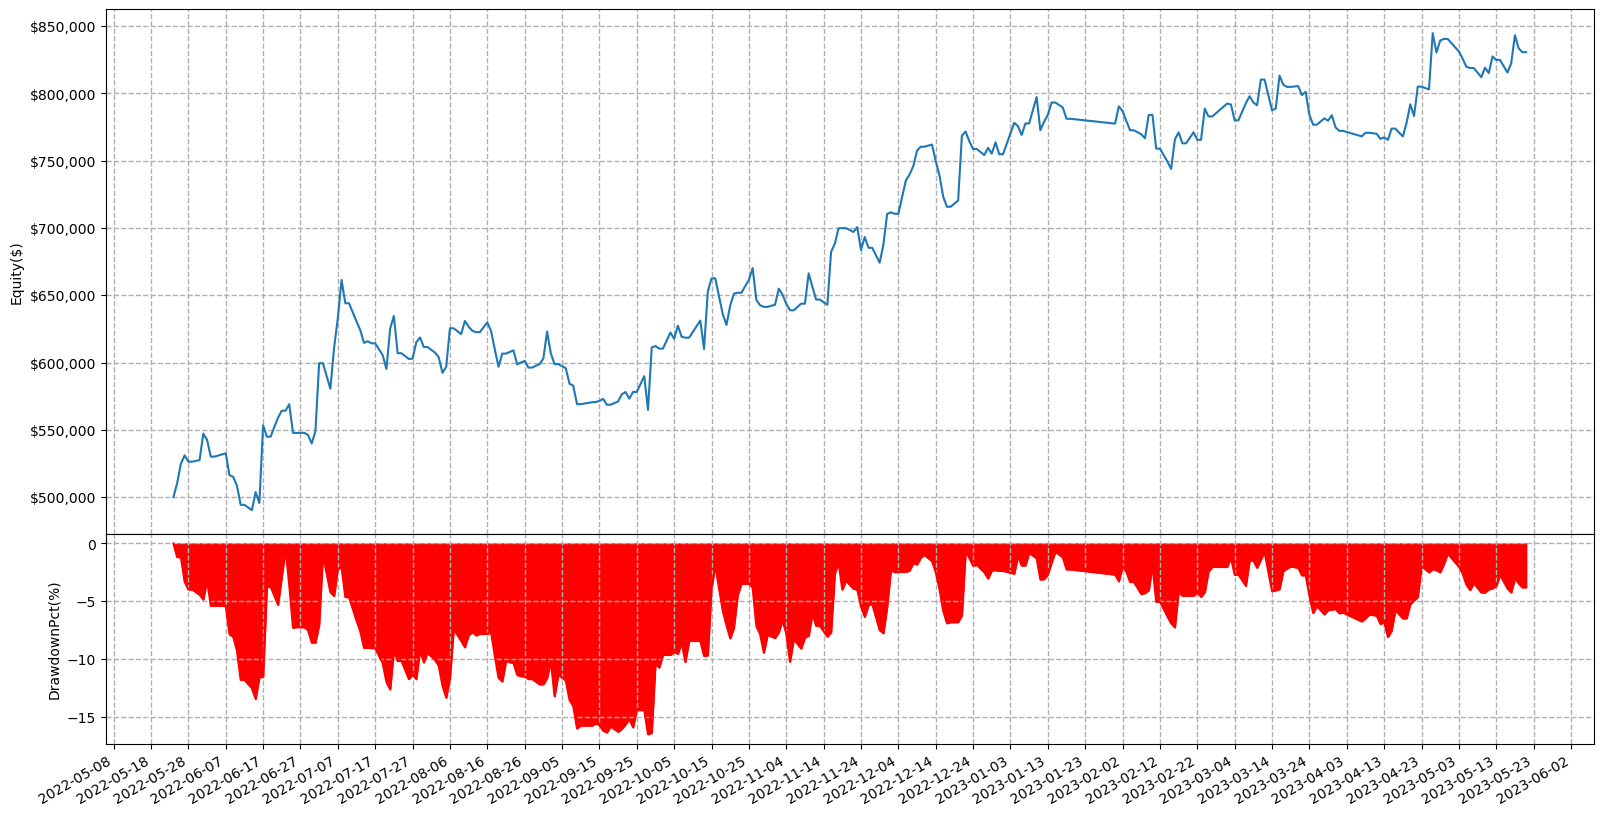

In [43]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib.ticker import StrMethodFormatter
from backtesting.lib import _EQUITY_AGG

equity_data = stats._equity_curve.resample('1D', label='right').agg(_EQUITY_AGG).dropna(how='all')
equity_data['DrawdownPct'] = equity_data['DrawdownPct'].multiply(-100)

f, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(19.2, 10.8), gridspec_kw={'height_ratios': [5, 2]})

ax1.grid(linestyle = '--', linewidth = 1)
ax1.plot(equity_data['Equity'])
ax1.set(ylabel="Equity($)")
ax1.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))
date_form = DateFormatter("%Y-%m-%d")
ax1.xaxis.set_major_formatter(date_form)
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=10))
ax2.grid(linestyle = '--', linewidth = 1)
ax2.plot(equity_data['DrawdownPct'], color="red")
ax2.set(ylabel="DrawdownPct(%)")
ax2.fill_between(equity_data['DrawdownPct'].index, equity_data['DrawdownPct'], where=(equity_data['DrawdownPct'] <= 0), color="red")   
f.subplots_adjust(hspace=0)
f.autofmt_xdate()

plt.show()

In [44]:
# bt = Backtest(df_in_sample, WL, cash=500_000, commission=0.000033, hedging=False, exclusive_orders=False, margin=0.05)
# stats = bt.optimize(
#                     n1=range(5, 30, 5),
#                     n2=range(20, 70, 5), 
# #                     OB=range(-5, -35, -5),
# #                     OS=range(-95, -65, 5),
# #                     stop_pct=range(1, 10, 2),
# #                     L=range(2,10,1),
#                     maximize='Equity Final [$]',
#                     ) # 快線週期<慢線週期
# print(stats.to_string())

## out sample

Start                     2023-01-30 08:50:00
End                       2023-05-20 05:00:00
Duration                    109 days 20:10:00
Exposure Time [%]                   11.516121
Equity Final [$]                  553120.6004
Equity Peak [$]                   585687.1042
Return [%]                           10.62412
Buy & Hold Return [%]                4.078335
Return (Ann.) [%]                   32.672075
Volatility (Ann.) [%]               42.996419
Sharpe Ratio                         0.759879
Sortino Ratio                        1.846661
Calmar Ratio                         2.679897
Max. Drawdown [%]                  -12.191541
Avg. Drawdown [%]                   -2.447188
Max. Drawdown Duration       40 days 00:50:00
Avg. Drawdown Duration        4 days 08:23:00
# Trades                                  305
Win Rate [%]                        39.016393
Best Trade [%]                       1.336316
Worst Trade [%]                     -0.371101
Avg. Trade [%]                    

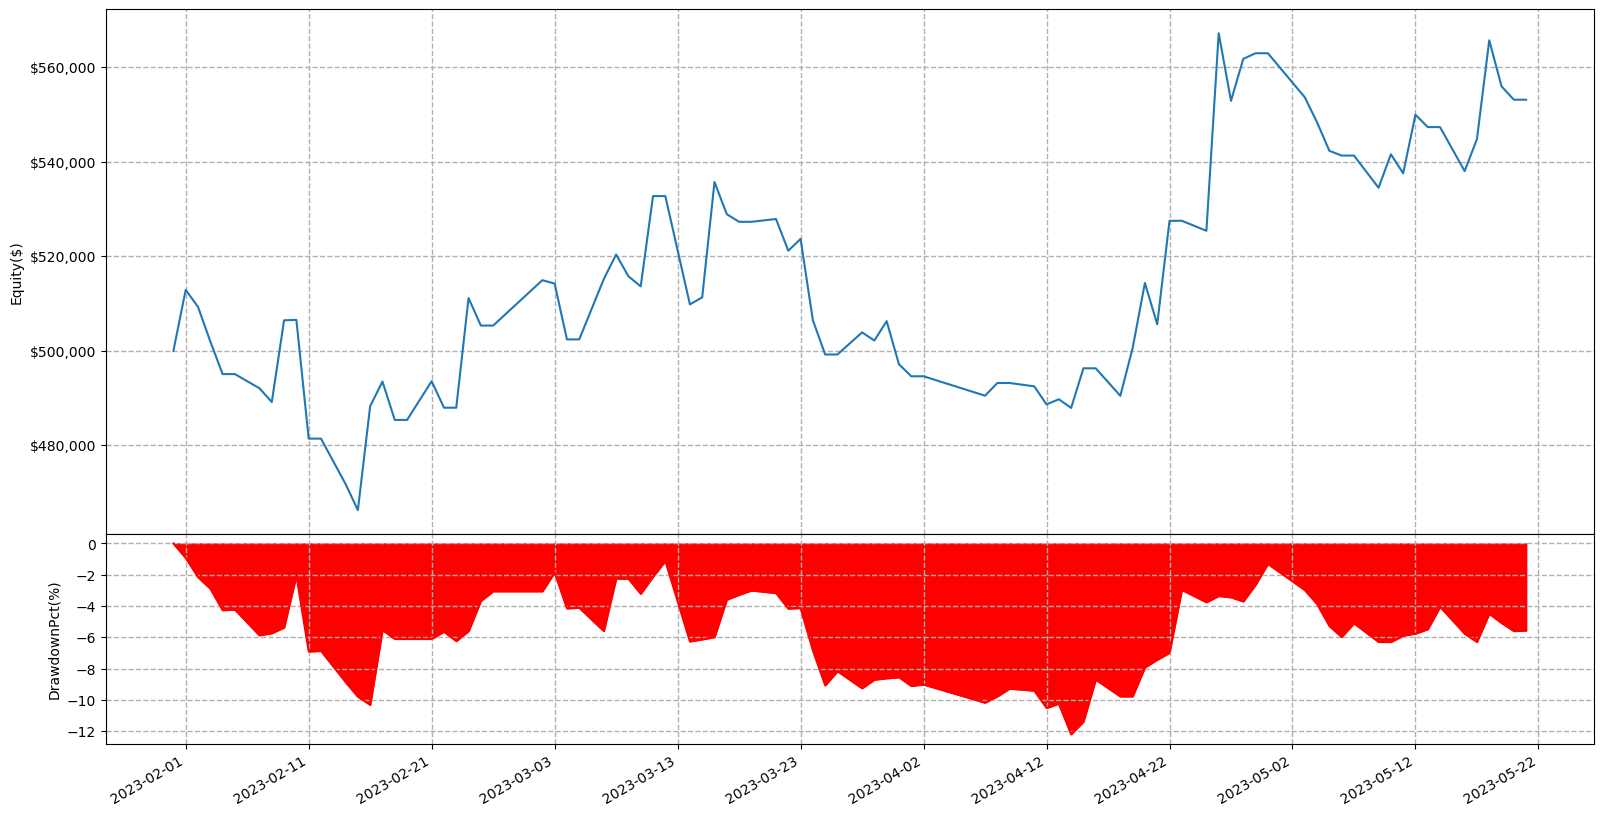

SDK NOTICE Tue May 30 05:17:24.817 2023 solClient.c:12194                    (30cfc8000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/A131461990/0529/020829/127332/118.166.84.229', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP 203.66.91.161:80', connection 'tcp_TxRx' local address 'IP 192.168.1.8:58966'


Response Code: 0 | Event Code: 12 | Info: solClient.c:12194                    (30cfc8000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/A131461990/0529/020829/127332/118.166.84.229', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP 203 | Event: Session reconnecting
Response Code: 0 | Event Code: 13 | Info: host '203.66.91.161:80', hostname '203.66.91.161:80' IP 203.66.91.161:80 (host 1 of 1) (host connection attempt 1 of 1) (total reconnection attempt 7 of 10) | Event: Session reconnected
Response Code: 0 | Event Code: 12 | Info: solClient.c:12194                    (30cfc8000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/A131461990/0529/020829/127332/118.166.84.229', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP 203 | Event: Session reconnecting
Session Down.
Response Code: 0 | Event Code: 1 | Info: solClientOS.c:4470                   (30cfc8000) TCP connecti

In [45]:
bt = Backtest(df_out_sample, WL, cash=500_000, commission=0.000033, hedging=False, exclusive_orders=False, margin=0.05)
stats = bt.run()
print(stats)
equity_data = stats._equity_curve.resample('1D', label='right').agg(_EQUITY_AGG).dropna(how='all')
equity_data['DrawdownPct'] = equity_data['DrawdownPct'].multiply(-100)

f, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(19.2, 10.8), gridspec_kw={'height_ratios': [5, 2]})

ax1.grid(linestyle = '--', linewidth = 1)
ax1.plot(equity_data['Equity'])
ax1.set(ylabel="Equity($)")
ax1.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))
date_form = DateFormatter("%Y-%m-%d")
ax1.xaxis.set_major_formatter(date_form)
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=10))
ax2.grid(linestyle = '--', linewidth = 1)
ax2.plot(equity_data['DrawdownPct'], color="red")
ax2.set(ylabel="DrawdownPct(%)")
ax2.fill_between(equity_data['DrawdownPct'].index, equity_data['DrawdownPct'], where=(equity_data['DrawdownPct'] <= 0), color="red")   
f.subplots_adjust(hspace=0)
f.autofmt_xdate()

plt.show()